

# **👪💰📈 > Customer Segmentation and Lifetime Value Prediction Using ML < 📈💰👪**



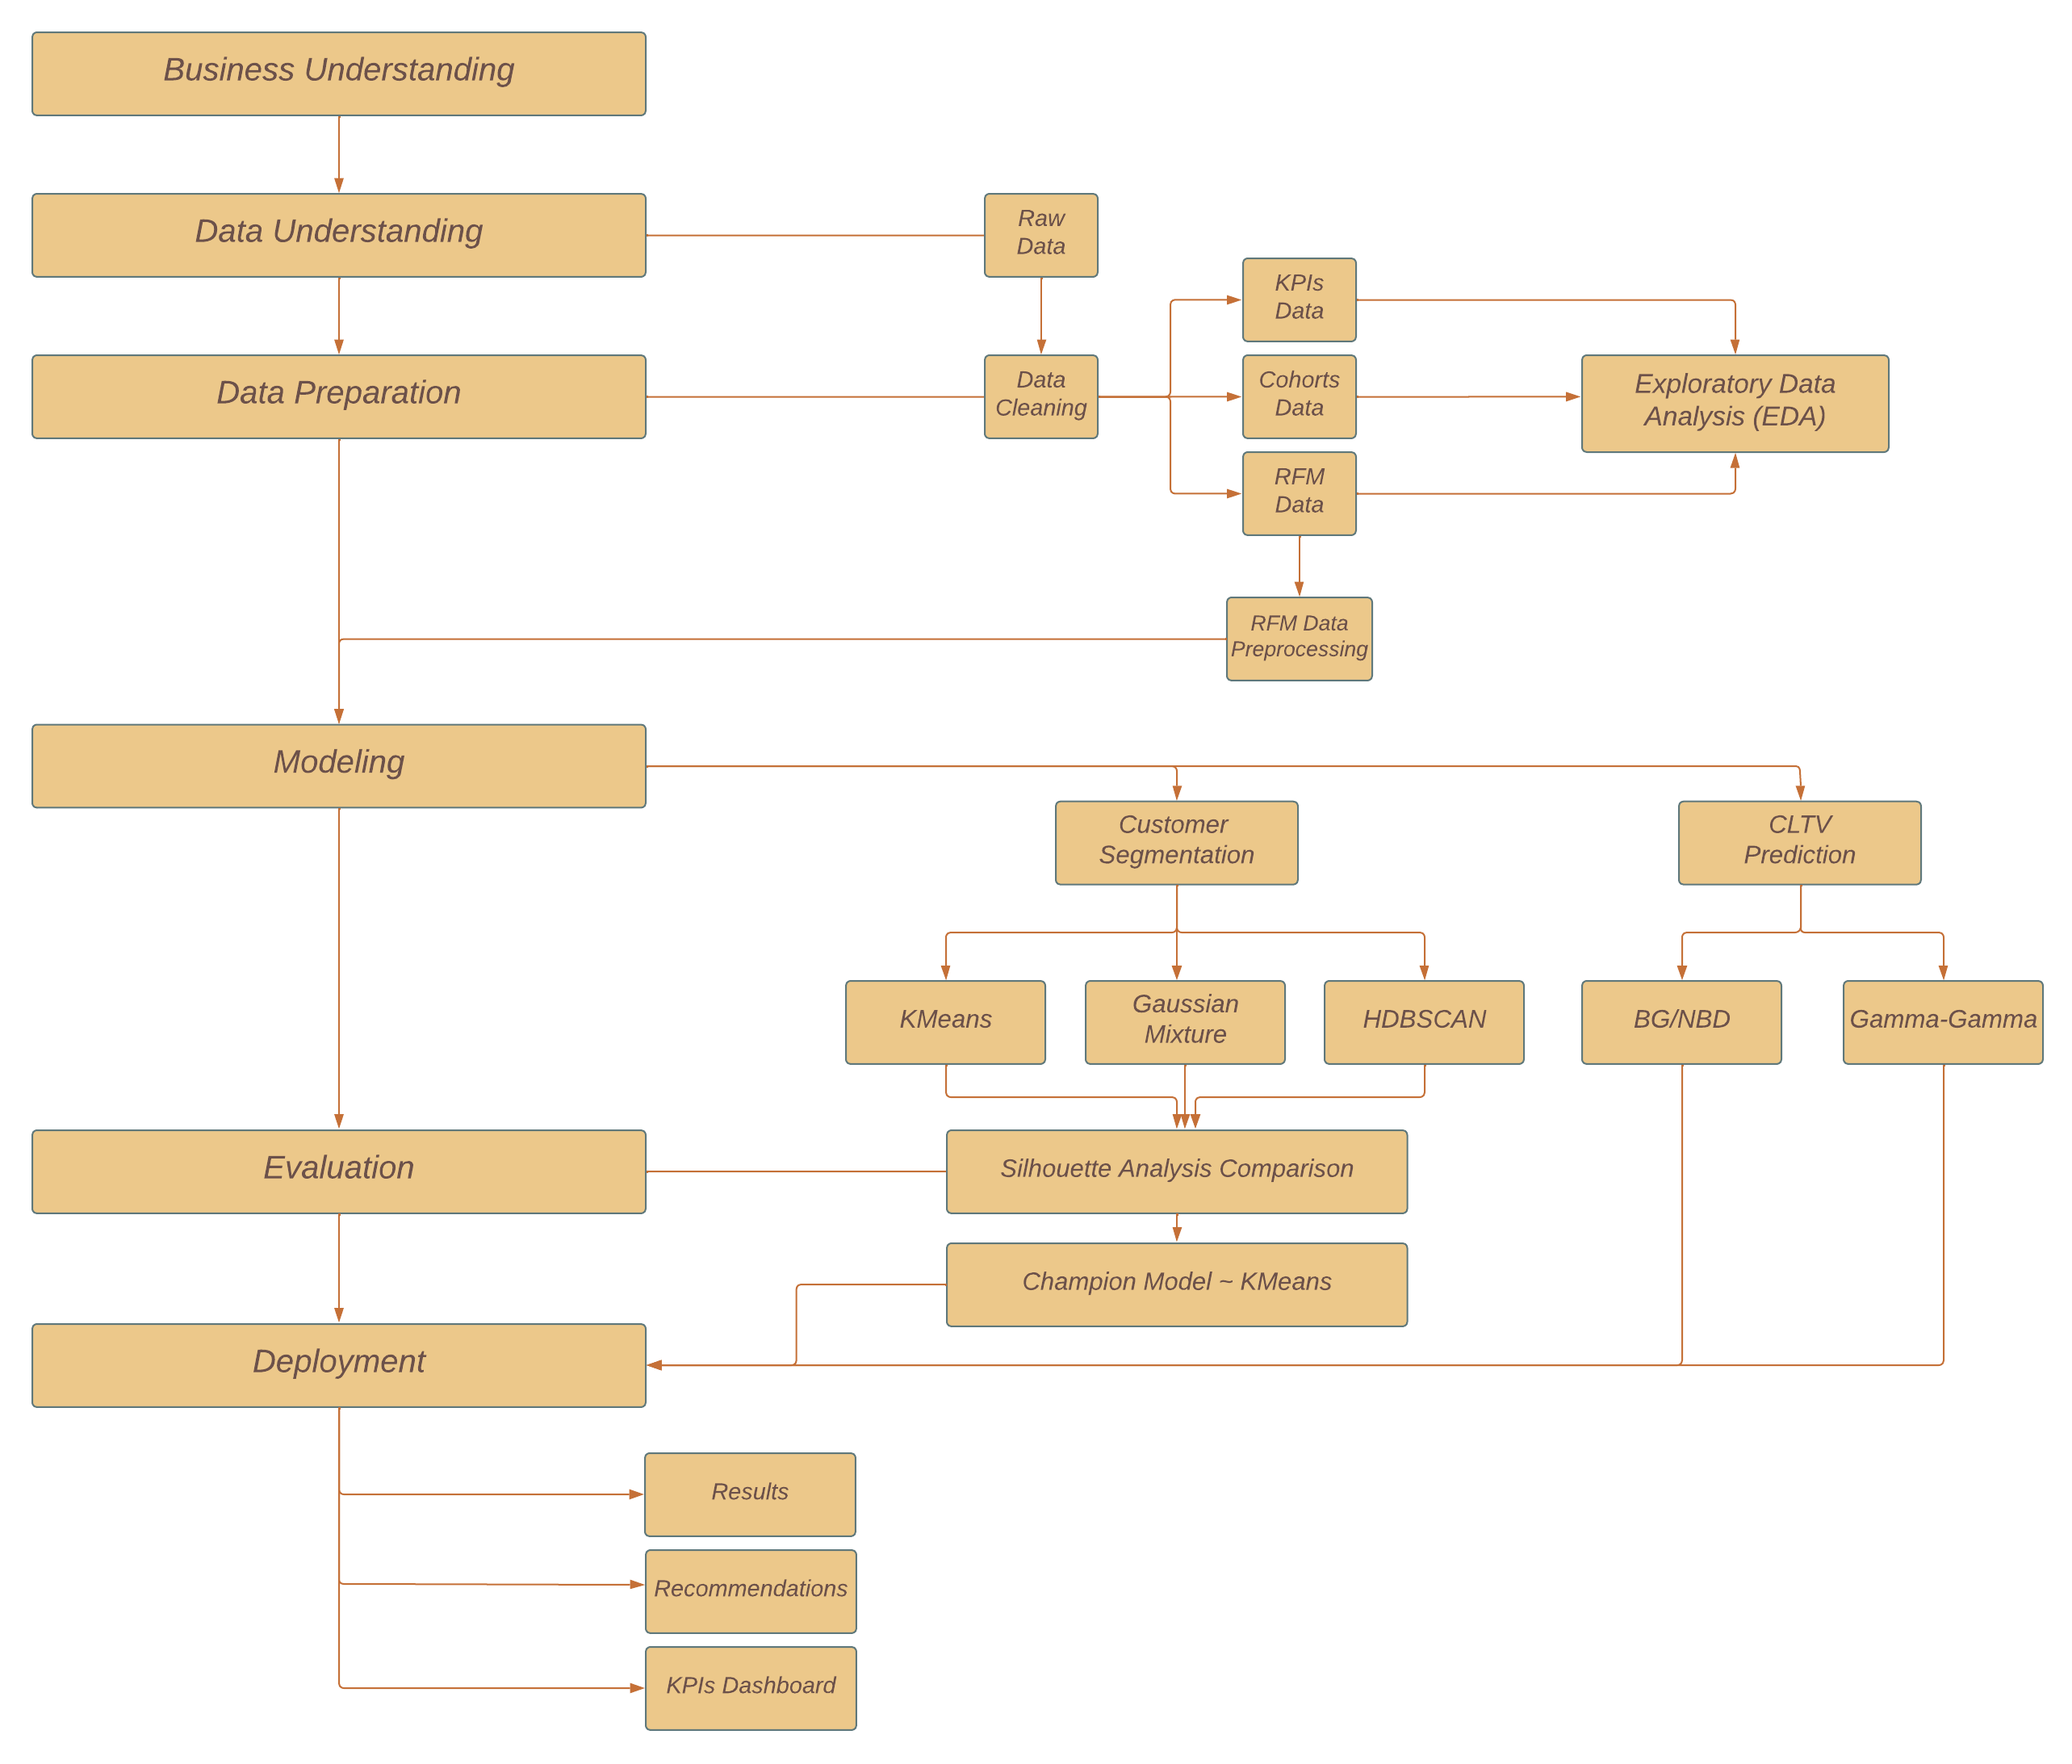

## **1. Business Understanding** 

### **1.1 Background** 

  - XYZ is an Egyptian <u>online retail</u> start-up where the <u>marketing</u> team needs to run marketing more <u>effectively yet efficiently</u>. As a start-up, its performance is acceptable, however, it can perform rather better once the <u>problems</u> they face got solved.

### **1.2 Problems** 

1. <u>Fluctuations</u> in the number of orders made by customers.

2. Many customers <u>churned</u> from XYZ. 

3. Marketing campaigns' <u>impact</u> on business performance is not measurable.

### **1.3 Objectives** 

1. Launching <u>customized accurately targeted</u> marketing campaigns to maintain <u>high monthly orders</u>.

2. Planning for <u>feasible reactivation and retention</u> marketing campaigns.

3. Measuring <u>marketing activities' impact</u> on the business.

### **1.4 Questions** 

1. What are the <u>customer groups</u> based on their ordering behaviors? <u>(i.e *recency, frequency and monetary value*)</u>

2. What are the customers' future <u>worth/value</u> based on their ordering behaviors?


3. What are the <u>crucial KPIs</u> of the business?

### **1.5 Analytics Solutions / Methodologies**

1. Using ML Clustering models to conduct <u>RFM Customer Segmentation</u>.

2. Using BG/NBD & Gamma-Gamma Models to <u>predicting Customer lifetime value</u>.

3. Building a <u>business intelligence (BI) dashboard</u> to keep track of XYZ's. business performance

### **1.6 Required Data**

- Last 12 months of <u>orders' transactions data</u>.

## **2. Data Understanding**

### 2.1 Importing packages

In [ ]:
# !pip install pandasql
# !pip install lifetimes
# !pip install missingno
# !pip install hdbscan
import warnings
import lifetimes
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as ps
import datetime as dt
import missingno as msno
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 
sns.despine()
sns.set(style='darkgrid')
sns.set_palette('flare_r')
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, linewidth=100, precision=5)

<Figure size 576x396 with 0 Axes>

### 2.2 Collecting Data

In [ ]:
df_raw = pd.read_csv('00 data-orders.csv')
df_raw.to_csv('01 data-raw.csv', index=False)
df_raw.head()

,Order Id,Order DateTime,Order Price,User Id,Quantity
0,211216115328MQGI,2021-12-16 08:53:28.892884,238.00,2745796d-645c-4213-8747-2212df3f8d77,1
1,211216113832JZAP,2021-12-16 08:38:32.456324,48.25,f1f91bf0-45c9-4aeb-a633-50f97ac30c88,1
2,211216123102CECL,2021-12-16 09:31:02.873546,67.00,a4f2c5a2-307e-4681-b529-8c6d4ef13e43,1
3,211216131223HJOU,2021-12-16 10:12:23.858028,142.00,262dbd76-07e4-4682-a8be-139a5438a25d,1
4,211216125120ETXE,2021-12-16 09:51:20.224149,70.00,a11c443b-dc33-44c3-85c6-c3f5224f0aa8,1


### 2.3 Data Dictionary

- **About:** This is the ordering transactional data set that contains all of the last 12 months’ transactions.
- **Date:** 30th September 2021 to 31st October, 2022
- **Rows:** 1,276,436 rows
- **Columns:** 5 columns
- **Data Dictionary:**

| Column Name | Description | Sample Value  |
|-------------|-------------|---------------|
| Order Id    | The order's unique Id  | 211216115328MQGI |
| Order DateTime | The date/time when the order made | 2021-12-16 08:53:00 |	
| Order Price | The order's value  | 48.00 |
| User Id     | The user's id who made the order  | 2745796d-645c	|
| Quantity    | The ordered quantity  | 1 |

## **3. Data Preparation**

### 3.1 Data Cleaning


Duplicates Count:
------------------
False    1276436
dtype: int64

Data Types:
------------------
order_id                  object
order_datetime    datetime64[ns]
order_price              float64
user_id                   object
quantity                   int64
dtype: object

Columnwise Null values:
----------------------
order_id          0
order_datetime    0
order_price       0
user_id           0
quantity          0
dtype: int64


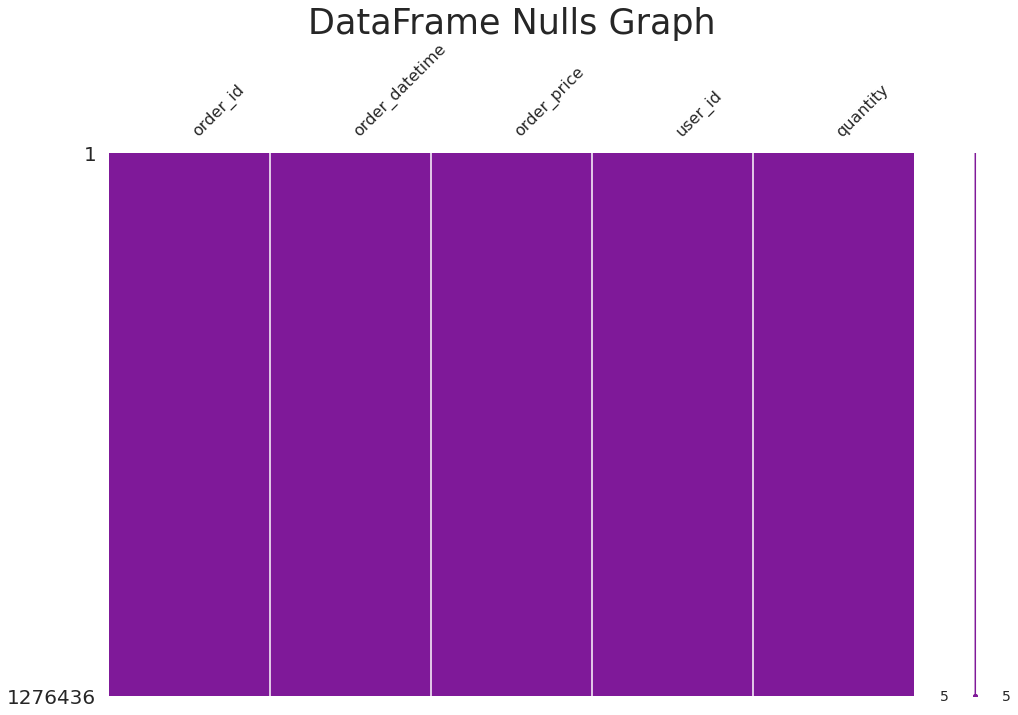

,order_id,order_datetime,order_price,user_id,quantity
26343,211223214940IIUH,2021-12-23 18:49:40.596694,0.0,1d2432b8-50c2-497f-bcbf-b81fb14b9639,1
257325,220315163645FEDB,2022-03-15 13:36:45.430322,24.0,1550a927-f6df-4259-b147-f5008724c878,1
172212,220209193659WZTA,2022-02-09 16:36:59.710620,88.0,457aa58a-c145-402d-8681-38fa68d3872d,1


In [ ]:
# renaming the columns to be in lowercase separated by '_' instead of spaces (i.e following the same naming convention)
df_raw.rename( columns= lambda x : x.strip().lower().replace(' ','_'), inplace = True)

# modifying columns data types
df_raw['order_datetime'] = pd.to_datetime(df_raw['order_datetime'], infer_datetime_format=True, errors='coerce')

# modifying out of range order_price values (i.e replace by mean for prices >500 or <0)
df_raw['order_price'] = np.where(df_raw['order_price'] >= 500, 500, df_raw['order_price'])
df_raw['order_price'] = np.where(df_raw['order_price'] <= 0, 0, df_raw['order_price'])

# checking for duplicates
print(f'\nDuplicates Count:\n------------------\n{df_raw.duplicated().value_counts()}')

# checking for datatypes
print(f'\nData Types:\n------------------\n{df_raw.dtypes}')

# checking for Nulls
print(f'\nColumnwise Null values:\n----------------------\n{df_raw.isnull().sum()}')
msno.matrix(df_raw.sort_values('order_datetime'), figsize=(16,10), color =(0.5,0.1,0.6));
plt.title('DataFrame Nulls Graph', fontsize=35)
plt.show()

# sorting our dataframe by order_datetime
df_clean = df_raw.sort_values( by = ['order_datetime'], ascending= True)

# exporting the data after cleaning
df_clean.to_csv('02 data-cleaned.csv', index=False)
print('\n\n')
df_clean.sample(3)

### 3.2 RFM Data

In [ ]:
## Recency: indicates when a customer made his/her last order
## Tenure: indicates the lifetime period of the customer with the analysis scope (i.e customer age with the company)
## Frequency: refers to the number of orders made in the scope of the analysis
## Monetary value: refers to the amount of money spent on orders
## snap_date: the date when the data was extracted and the analysis was conducted (i.e the scope of the analysis)

snap_date = dt.datetime(2022, 11, 1)   
rfm_data = df_clean.groupby('user_id').agg({ 'order_datetime': [lambda x: (snap_date - x.max()).days, lambda x: (snap_date - x.min()).days],
                                             'order_id': pd.Series.nunique,
                                             'order_price': np.sum}).reset_index()
rfm_data.columns = ['user_id', 'recency (in days)', 'tenure (in days)', 'frequency', 'monetary']
rfm_data.to_csv('03 data-rfm.csv', index=False)
rfm_data.sample(3)

,user_id,recency (in days),tenure (in days),frequency,monetary
148234,5a3fe355-25c4-47b0-af5c-de82b7ec4a6a,40,40,1,58.0
400832,f4074970-611e-4485-85f9-e248f61f3f58,160,160,1,37.0
33729,14643883-0b4b-44a4-a481-ea659ffd8b9d,32,32,1,26.0


### 3.3 Cohort Data

In [ ]:
## preparing cohort analysis data
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_clean['order_month'] = df_clean['order_datetime'].apply(get_month)
grouping = df_clean.groupby('user_id')['order_month']
df_clean['cohort_month'] = grouping.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
order_year, order_month, _ = get_date_int(df_clean, 'order_month')
cohort_year, cohort_month, _ = get_date_int(df_clean, 'cohort_month')
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month
df_clean['cohort_index'] = years_diff * 12 + months_diff  + 1
df_clean['cohort_index'] = df_clean[['cohort_index']].astype('Int64', errors='ignore')

## Active Merchants Cohorts
active_user_cohorts = pd.pivot_table(data=df_clean,
                                     index='cohort_month',
                                     columns ='cohort_index',
                                     values = 'user_id',
                                     aggfunc = pd.Series.nunique,
                                     fill_value=0)
active_user_cohorts.index = active_user_cohorts.index.strftime("%b %Y")
active_user_cohorts.to_csv('04 data-active-cohorts.csv', index=True)
print(active_user_cohorts.sample(3))
print('\n\n')

## Retention Cohorts
cohort_sizes = active_user_cohorts.iloc[:,0]
retention_cohorts = active_user_cohorts.divide(cohort_sizes, axis=0).round(3)*100
retention_cohorts.to_csv('05 data-retained-cohorts.csv', index=True)
print(retention_cohorts.sample(3))

cohort_index     1      2      3     4      5     6     7     8     9     10  \
cohort_month                                                                   
Apr 2022      20406   3957   3019  2760   2197  2066  2075     0     0     0   
Sep 2022      29732   6636      0     0      0     0     0     0     0     0   
Nov 2021      48537  15654  12326  9643  10316  6977  9958  9435  9312  8183   

cohort_index    11    12  13  
cohort_month                  
Apr 2022         0     0   0  
Sep 2022         0     0   0  
Nov 2021      7964  8021   0  



cohort_index     1     2     3     4    5     6     7     8     9     10  \
cohort_month                                                               
Sep 2022      100.0  22.3   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
Dec 2021      100.0  21.0  13.7  14.9  9.3  13.9  12.9  13.1  11.0  10.8   
Jul 2022      100.0  16.9  11.0   9.8  0.0   0.0   0.0   0.0   0.0   0.0   

cohort_index    11   12   13  
cohort_month                 

### 3.4 Monthly KPIs

In [ ]:
query = \
'''
SELECT
  order_month AS "Month",
  COUNT(DISTINCT user_id) AS "#_active_users",
  COUNT(DISTINCT order_id) AS "#_orders",
  SUM(order_price) AS "revenues"
FROM df_clean
GROUP BY order_month
ORDER BY order_datetime ASC
'''
monthly_kpis = ps.sqldf(query)
monthly_kpis['Month'] = pd.to_datetime(monthly_kpis['Month'])
monthly_kpis['Month'] = monthly_kpis['Month'].apply(lambda x: get_month(x).strftime("%b %Y"))
monthly_kpis['revenues'] = monthly_kpis.revenues.astype(int)
monthly_kpis.to_csv('06 data-monthly-kpis.csv', index=False)
monthly_kpis.sample(3)

,Month,#_active_users,#_orders,revenues
12,Oct 2022,80860,159443,8949999
1,Nov 2021,49164,79279,4790153
0,Oct 2021,1237,1253,75133


### 3.5 Preprocessing Data

In [ ]:
## selecting features
x = rfm_data[['user_id', 'recency (in days)', 'frequency', 'monetary']]
x.set_index('user_id', inplace = True)

## scaling features
x_scaled = StandardScaler().fit(x).transform(x)
x_scaled

array([[ 1.29545, -0.3605 , -0.25868],
       [-0.23434, -0.3605 , -0.1684 ],
       [ 0.17938,  0.34795,  0.22991],
       ...,
       [ 0.03506, -0.3605 ,  0.1529 ],
       [ 1.78613, -0.3605 , -0.27461],
       [-0.96556, -0.3605 , -0.40738]])

## **4. Exploratory Data Analysis (EDA)**

### 4.1 RFM EDA

In [ ]:
############################
## RFM SUMMARY STATISTICS ##
############################
rfm_summary = rfm_data[['recency (in days)', 'tenure (in days)', 'frequency','monetary']].describe(include="all").round(0).astype('int')
rfm_summary.to_csv('07 data-rfm-summary.csv')
display(rfm_summary)

,recency (in days),tenure (in days),frequency,monetary
count,420511,420511,420511,420511
mean,134,184,3,183
std,104,109,6,377
min,0,0,1,0
25%,45,95,1,40
50%,112,170,1,78
75%,210,288,3,178
max,365,365,305,21220


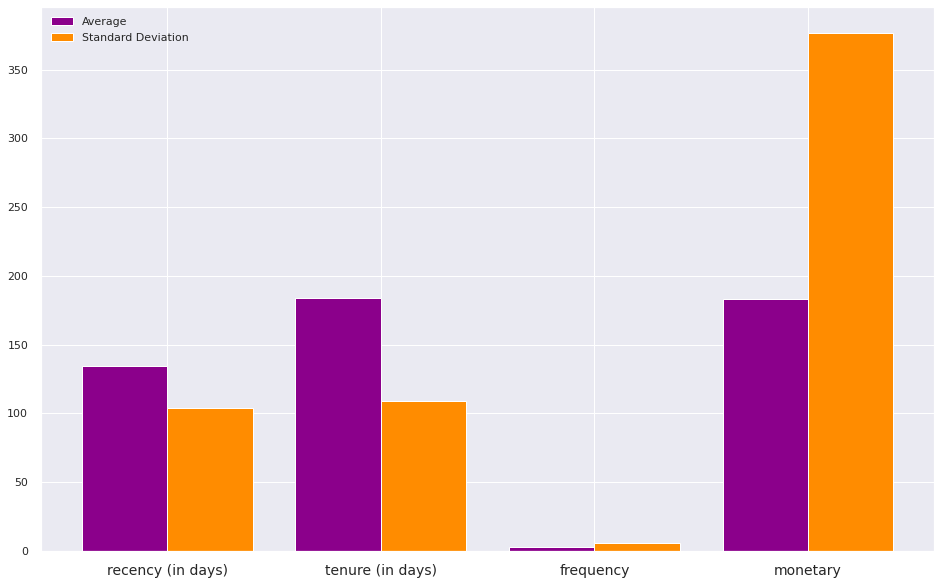

<Figure size 576x396 with 0 Axes>

In [ ]:
###########################################################
## RFM SUMMARY STATISTICS VISUALIZATION (i.e mean & std) ##
###########################################################
def summary_viz(X):
  averages = X.mean()
  st_dev = X.std()
  x_names = X.columns
  x_ix = np.arange(X.shape[1])
  plt.figure(figsize=(16, 10));
  plt.bar(x_ix-0.2, averages, color='darkmagenta', label='Average', width=0.4);
  plt.bar(x_ix+0.2, st_dev, color='darkorange', label='Standard Deviation', width=0.4);
  plt.xticks(x_ix, x_names, fontsize=14);
  plt.legend();
  plt.show();
  plt.savefig('rfm_avgs-stds.png');
summary_viz(rfm_data[['recency (in days)', 'tenure (in days)', 'frequency','monetary']]);

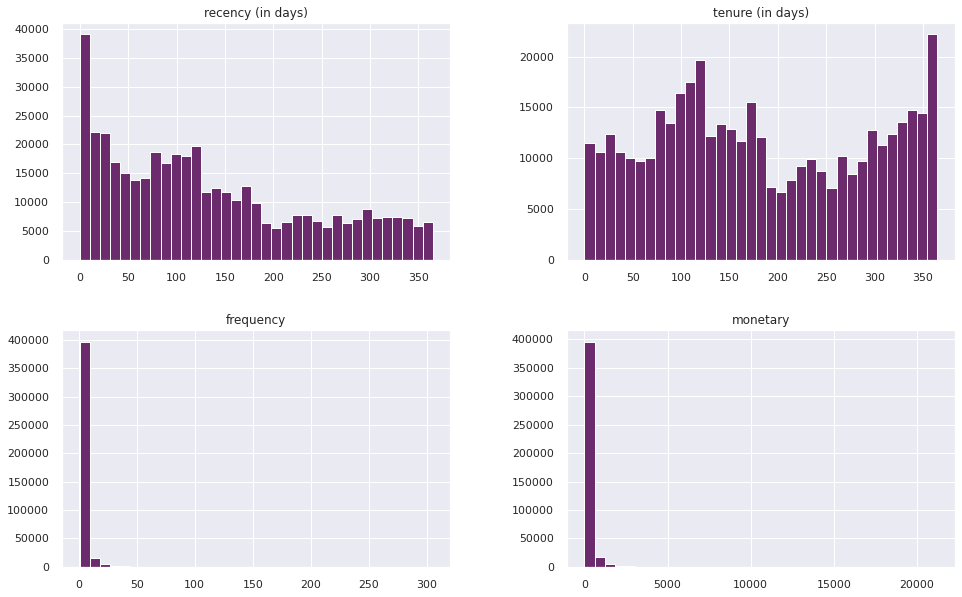

In [ ]:
##################################
## RFM ATTRIBUTES DISTRIBUTIONS ##
##################################
rfm_data[['recency (in days)', 'tenure (in days)', 'frequency','monetary']].hist(bins=35, figsize=(16, 10));
plt.savefig('rfm-distributions.png');

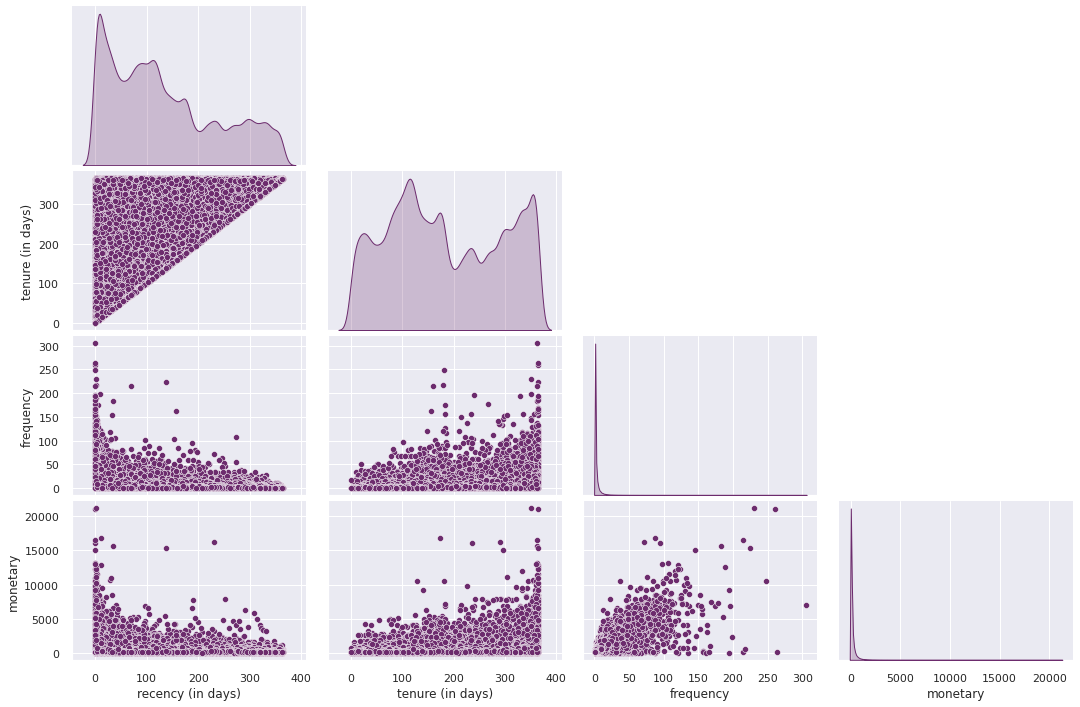

In [ ]:
##############################
## RFM ATTRIBUTES RELATIONS ##
##############################
g = sns.pairplot(rfm_data[['recency (in days)', 'tenure (in days)', 'frequency','monetary']], diag_kind='kde', corner=True);
g.fig.set_figheight(10);
g.fig.set_figwidth(16);
plt.savefig('rfm-relations.png');

### 4.2 Cohort Analysis EDA 

> Highlighting **Churn** Problems using Time-Based **Cohort Analysis**

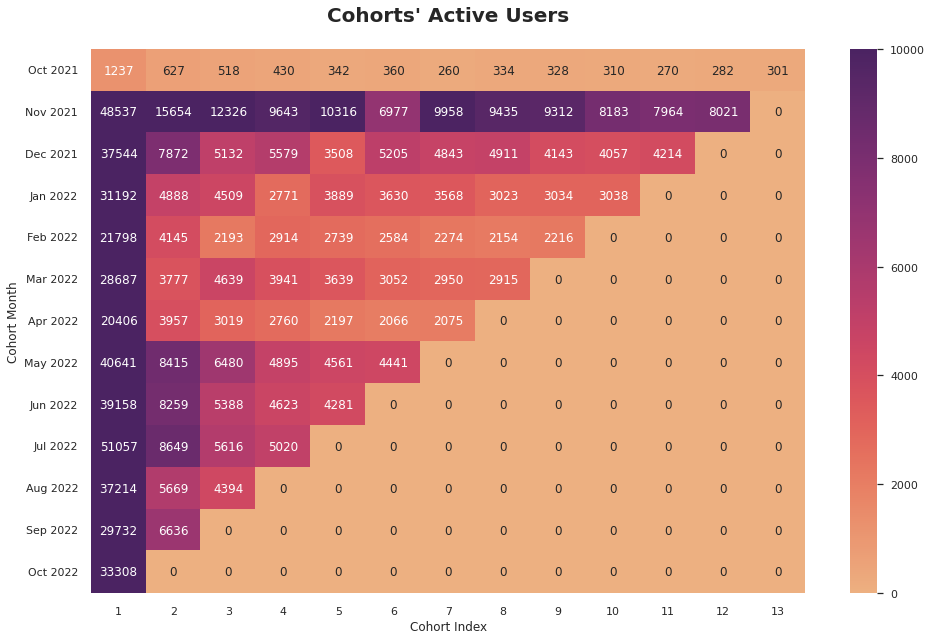

<Figure size 576x396 with 0 Axes>

In [ ]:
###########################
## Cohorts' Active Users ##
###########################
plt.figure(figsize=(16, 10)); plt.title('Cohorts\' Active Users\n', fontsize = 20, weight = "bold");
sns.heatmap(active_user_cohorts, annot = True, vmin = 0.0, vmax =10000, cmap='flare' , fmt='g');
plt.ylabel('Cohort Month'); plt.xlabel('Cohort Index');
plt.yticks( rotation='360'); plt.show();
plt.savefig('cohort-active-users.png');

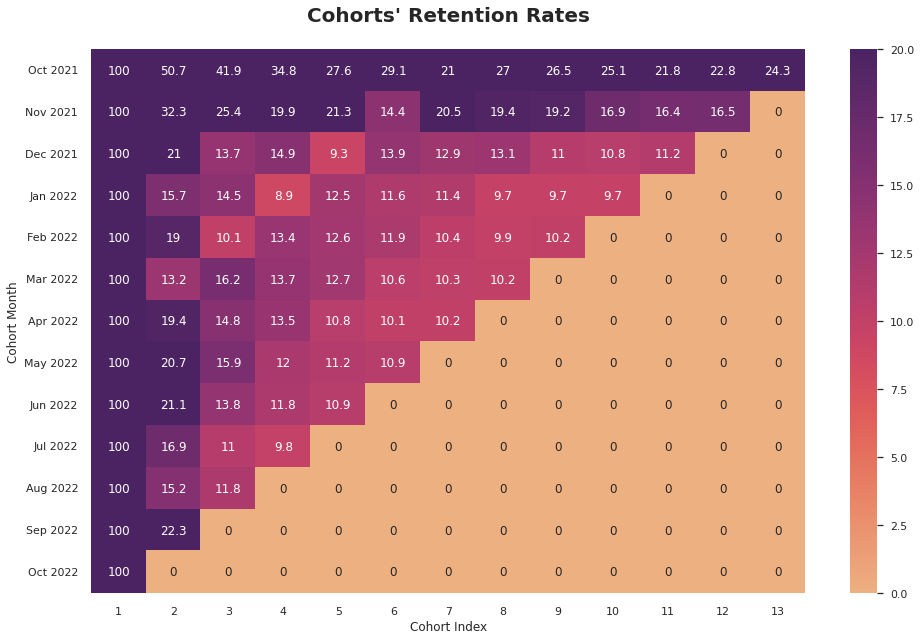

<Figure size 576x396 with 0 Axes>

In [ ]:
##############################
## Cohorts' Retention Rates ##
##############################
plt.figure(figsize=(16, 10)); plt.title('Cohorts\' Retention Rates\n', fontsize = 20, weight = "bold");
sns.heatmap(retention_cohorts, annot = True,vmin = 0.0, vmax =20, cmap='flare' , fmt='g');
plt.ylabel('Cohort Month');  plt.xlabel('Cohort Index');
plt.yticks( rotation='360'); plt.show();
plt.savefig('cohort-retention-rates.png');

### 4.3 Monthly KPIs EDA

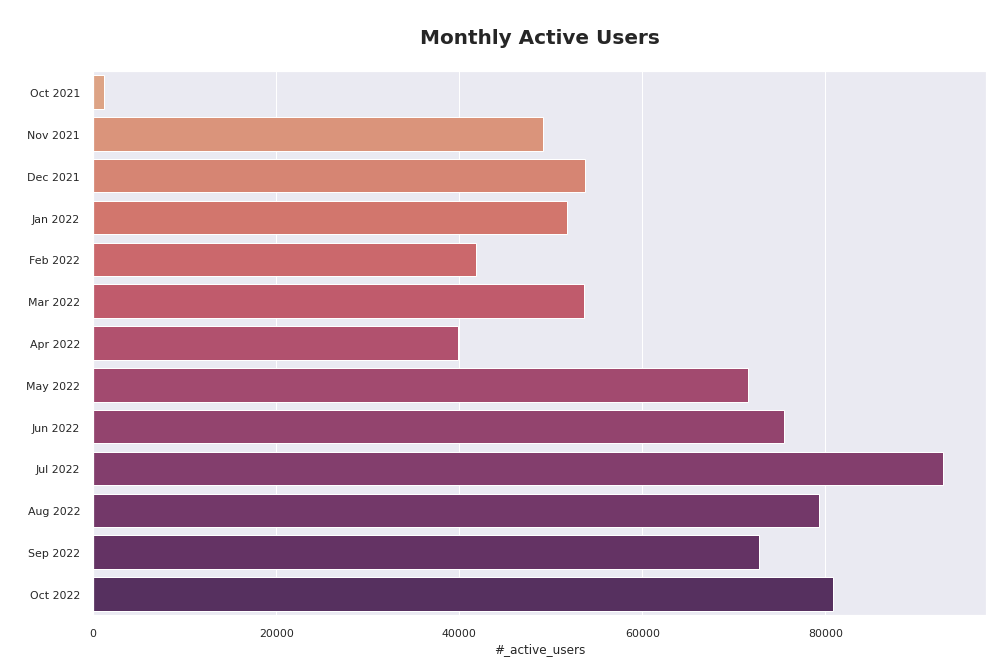

In [ ]:
##########################
## Monthly Active Users ##
##########################
plt.figure(figsize = (16, 10));
sns.barplot(data=monthly_kpis, y='Month', x='#_active_users', palette='flare');
plt.title('\nMonthly Active Users\n', fontsize=20, weight = "bold");
plt.ylabel(' ',fontsize=16);
plt.savefig('kpis-monthly-users.png');

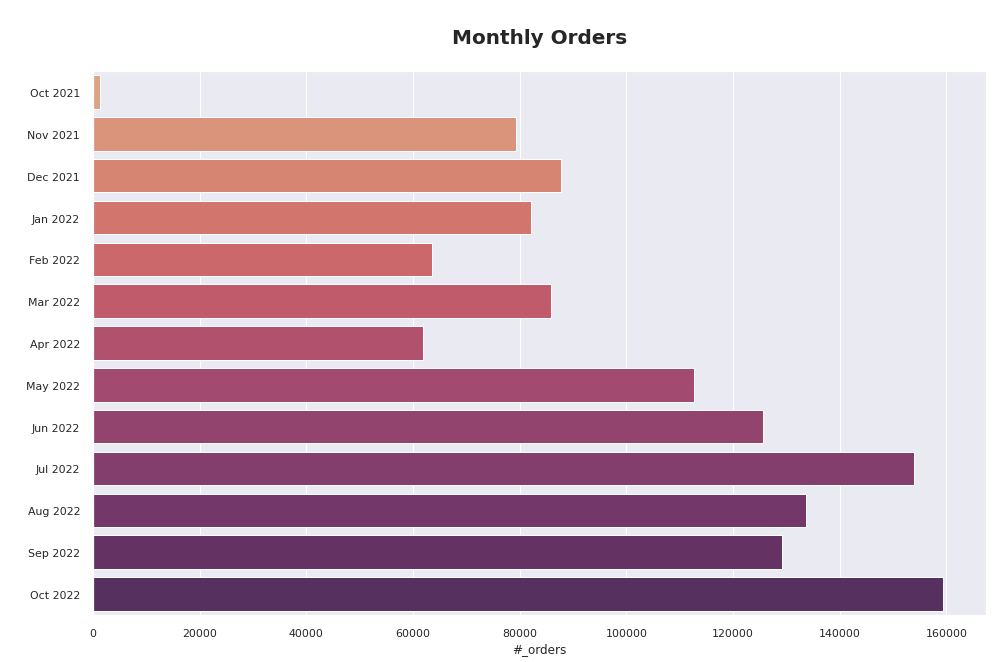

In [ ]:
####################
## Monthly Orders ##
####################
plt.figure(figsize = (16, 10));
sns.barplot(data=monthly_kpis, y='Month', x='#_orders', palette='flare');
plt.title('\nMonthly Orders\n', fontsize=20, weight = "bold");
plt.ylabel(' ',fontsize=16);
plt.savefig('kpis-monthly-orders.png');

## **5. Modeling & Evaluation**

### 5.1 Customer Segmentation Using ML Algorithm

##### 5.1.1 **KMeans** Clustering Algorithm

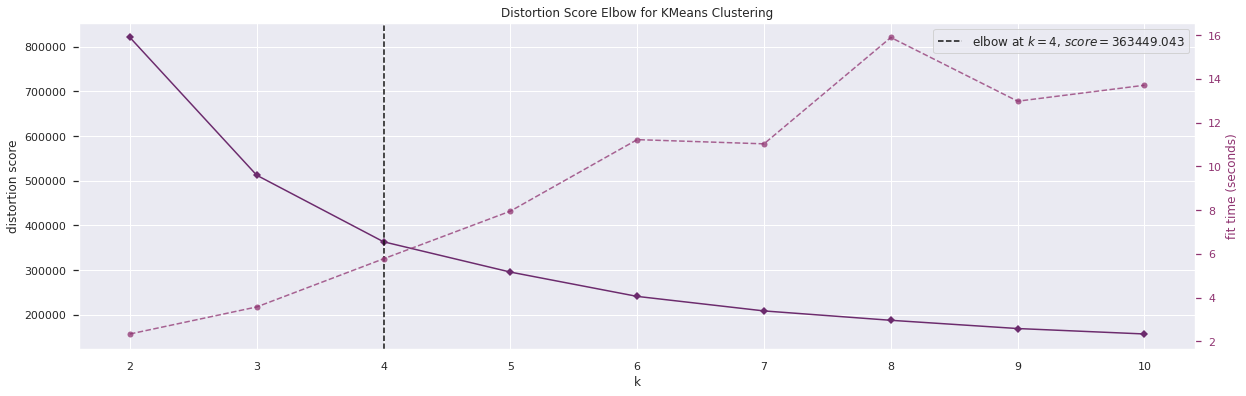

<Figure size 576x396 with 0 Axes>

In [ ]:
###########################################
## Finding the Best K (i.e elbow method) ##
#####################################################################################################################
## Distortion: computes the sum of squared distances from each point to its assigned cluster center ('distortion') ##
#####################################################################################################################
Elbow_M = KElbowVisualizer(KMeans(init='k-means++', random_state=96), k=(10), metric='distortion', timings=True, locate_elbow=True);
Elbow_M.fit(x_scaled);
g = Elbow_M; g.fig.set_figheight(6); g.fig.set_figwidth(20); g.show();
plt.savefig('KMeans-elbow-distortion.png');

In [ ]:
####################################################
## Computing Silhouette Scores to find the Best K ##
####################################################
for n_clusters in range(3,7):
    clusterer = KMeans(n_clusters, random_state=96);
    cluster_labels = clusterer.fit_predict(x_scaled);
    silhouette_avg = silhouette_score(x_scaled, cluster_labels, random_state=96);
    print("For no. of clusters =", n_clusters, ", The KMeans silhouette_score = ", round(silhouette_avg, 3));

For no. of clusters = 3 , The KMeans silhouette_score =  0.494
For no. of clusters = 4 , The KMeans silhouette_score =  0.521
For no. of clusters = 5 , The KMeans silhouette_score =  0.515
For no. of clusters = 6 , The KMeans silhouette_score =  0.433


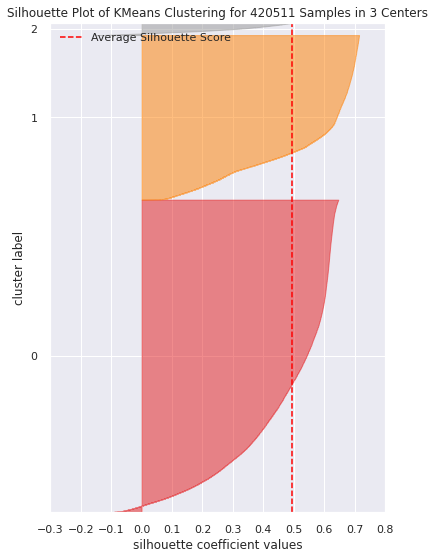

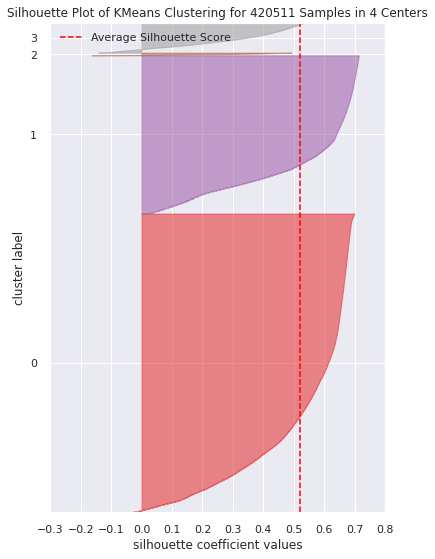

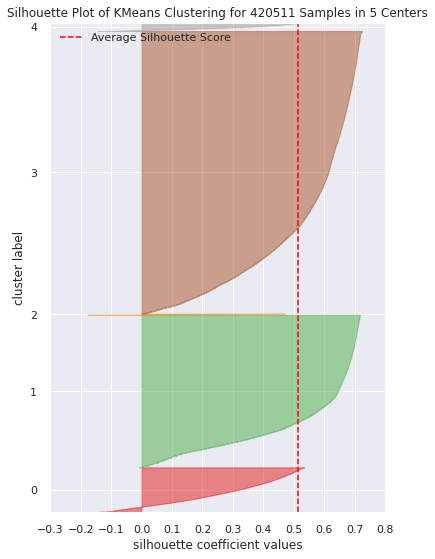

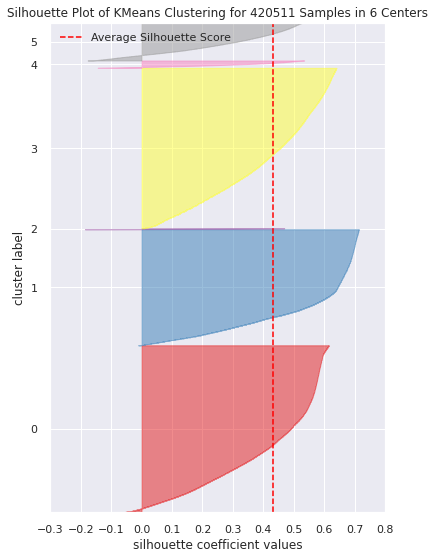

In [ ]:
####################################################
## Visualizing Silhouette Scores for different Ks ##
####################################################
for n_clusters in range(3,7):
    g = SilhouetteVisualizer(KMeans(n_clusters, random_state=96)).fit(x_scaled); g.fig.set_figheight(9); g.fig.set_figwidth(6); g.show();
    print('\n\n');

> With optimal number of clusters (i.e 4 clusters), the **KMeans' Silhouette score = 0.521**  

##### 5.1.2 **GaussianMixture** Clustering Algorithm 

In [ ]:
########################
## Building the model ##
########################
gmm = GaussianMixture(n_components = 3, random_state=96);
gmm_labels = gmm.fit_predict(x_scaled);

################################
## Computing Silhouette Score ##
################################
GM_silhouette = silhouette_score(x_scaled, gmm_labels, random_state=96);
print("The Gaussian Mixture Silhouette score = ", round(GM_silhouette, 3));

The Gaussian Mixture Silhouette score =  0.099


##### 5.1.3 **HDBSCAN** Clustering Algorithm 

In [ ]:
########################
## Building the model ##
########################
HDCN = HDBSCAN(min_samples=1,min_cluster_size=7,cluster_selection_method='leaf',metric='braycurtis');
HDCN_labels = HDCN.fit_predict(x_scaled);

################################
## Computing Silhouette Score ##
################################
HDBSCAN_silhouette = silhouette_score(x_scaled, HDCN_labels, random_state=96);
print("The HDBSCAN Silhouette score = ", round(HDBSCAN_silhouette, 3));

The HDBSCAN Silhouette score =  0.251


##### 5.1.4 Evaluation

<div align="center">

|          Algorithm             |      Silhouette Score         |
|--------------------------------|-------------------------------|
|<div align="center">KMeans</div>|<div align="center"><font color='green'>0.521</font></div>|
|<div align="center">GaussianMixture</div>|<div align="center"><font color='red'>0.099</font></div>|
|<div align="center">HDBSCAN</div>|<div align="center"><font color='red'>0.251</font></div>|

</div>

<div align="center">

The **KMeans** model with **4 clusters** shows **better** performance than the other algorithms according to the **Silhouette** score

</div>

##### 5.1.5 Deployment

In [ ]:
########################
## Building the model ##
########################
kmeans = KMeans(4, init='k-means++', random_state=96);
kmeans_labels = kmeans.fit_predict(x_scaled);

##########################################
## Assigning cluster to the users' data ##
##########################################
rfm_data['Cluster'] = kmeans_labels+1
rfm_data.to_csv('08 data-users-clustered.csv', index=False)
rfm_data.sample(3)

,user_id,recency (in days),tenure (in days),frequency,monetary,Cluster
97767,3b653f3c-e65f-40ba-9888-9bef0561d441,356,356,1,30.0,2
88086,35836484-c0ae-4c63-b489-c899bb4614f0,165,249,2,82.0,1
397636,f22bd1a8-96bb-4216-8d8c-123d194c4c10,363,363,1,33.0,2


### 5.2 Customer Lifetime Value **(CLTV)** Prediction 

In [ ]:
###################################
## Customer Lifetime Value (CLV) ##
################################### 
#########################################################################################
## CLV measures how much value a customer generates for the business                   ##
## CLV also helps marketers to manage the costs of customer acquisition and retention  ##
#########################################################################################


# only customers ordered: at least one 2 orders - at least from a day before
clv = rfm_data[rfm_data['frequency']>1]
clv = rfm_data[rfm_data['recency (in days)']>1]
clv = rfm_data[rfm_data['monetary']>1]

t = 180 # estimate period in days
time = 6 # prediction period in months


# fitting the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(clv['frequency'], clv['recency (in days)'], clv['tenure (in days)'])

# estimating the expected number of orders within 6 Months
clv['6_months_expected_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency (in days)'], clv['tenure (in days)']).round(2)


# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"], clv["monetary"])

# Predicting CLV for the Next 6 Months
clv['6_monhths_clv']=ggf.customer_lifetime_value(bgf, clv["frequency"], clv["recency (in days)"],
                                                 clv["tenure (in days)"], clv["monetary"],
                                                 time=time, freq='D', discount_rate=0.01).round(2)


# segmenting CLV into different groups
clv['segment'] =  pd.qcut(clv['6_monhths_clv'], 4, labels=['Hibernating', 'Need Attention', 'LoyalCustomers', 'Champions'])
clv.to_csv('09 data-users-clv.csv', index=False)
clv.sample(3)

,user_id,recency (in days),tenure (in days),frequency,monetary,Cluster,6_months_expected_orders,6_monhths_clv,segment
353686,d7a41d27-269e-4e2a-90ba-5811163f00b7,290,360,2,88.0,2,0.80,74.42,LoyalCustomers
319825,c2e868f5-c883-4dc5-b97a-04853d2c46bf,98,98,1,29.0,1,1.44,52.28,Need Attention
213176,8207b804-ad6f-40b2-8d39-c1cb046bd35c,36,360,3,353.0,1,0.01,2.49,Hibernating


## **6. Results**



### 6.1 RFM-Based Customer Segmentations

##### 6.1.1 Insights

In [ ]:
##############################
## RFM-BASED USERS PROFILES ##
##############################
user_clusters_profiles = rfm_data.groupby(['Cluster']).agg({'tenure (in days)': 'mean',
                                                            'recency (in days)': 'mean',
                                                            'frequency': 'mean',
                                                            'monetary': ['mean', 'count']}).round(0).astype('int')
user_clusters_profiles.columns = ['avg_tenure', 'avg_recency', 'avg_frequency', 'avg_monetary', '#_users']
user_clusters_profiles['%_users'] = (round(user_clusters_profiles['#_users']/user_clusters_profiles['#_users'].sum(), 2) * 100).astype('int').astype('str') + '%'
user_clusters_profiles['Name'] = ['Low-Spending About to Churned', 'Low-Spending Churned', 'Champions', 'Potential Loyalists']
user_clusters_profiles['Description'] = ['Users spent low amounts and about to churn',
                                         'Users spent low amounts and churned',
                                         'Users ordered most recently, most often, and are heavy spenders',
                                         'Users who ordered often and spent big amounts, but haven’t ordered recently']
user_clusters_profiles = user_clusters_profiles[['Name', '%_users', 'Description', 'avg_tenure', 'avg_recency', 'avg_frequency', 'avg_monetary', '#_users']]
user_clusters_profiles.to_csv('10 data-cluster-profiles.csv');
display(user_clusters_profiles)

,Name,%_users,Description,avg_tenure,avg_recency,avg_frequency,avg_monetary,#_users
Cluster,,,,,,,,
1,Low-Spending About to Churned,61%,Users spent low amounts and about to churn,126,76,2,127,256383
2,Low-Spending Churned,32%,Users spent low amounts and churned,276,264,2,91,135992
3,Champions,1%,"Users ordered most recently, most often, and a...",313,19,52,3425,2290
4,Potential Loyalists,6%,"Users who ordered often and spent big amounts,...",263,42,14,943,25846


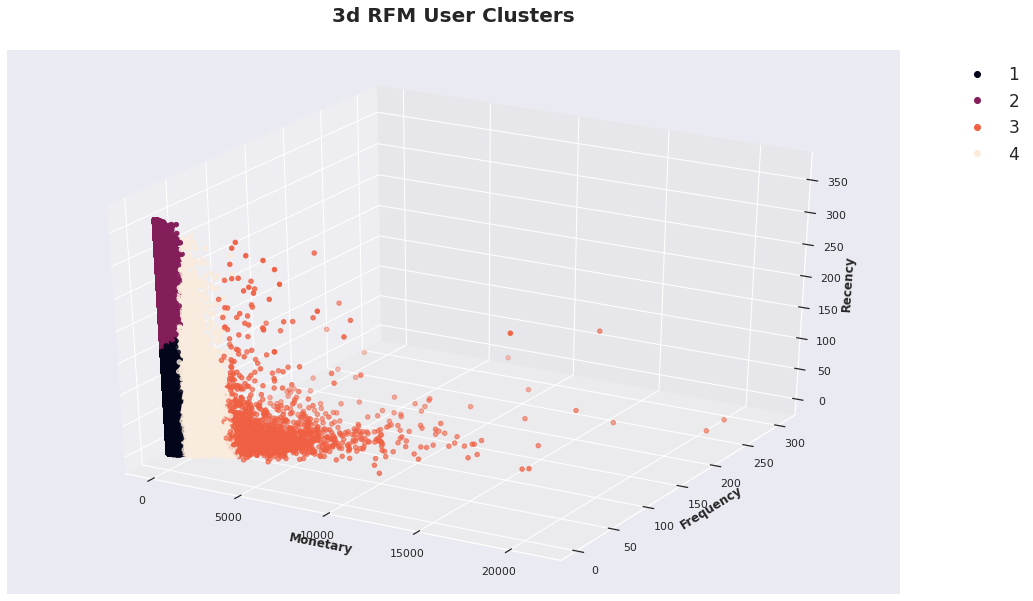

<Figure size 576x396 with 0 Axes>

In [ ]:
###################################
## 3d RFM Clusters Visualization ##
###################################
fig = plt.figure(figsize=(16, 10));
ax = fig.add_subplot(111, projection = '3d');
x = rfm_data['monetary']; ax.set_xlabel("Monetary",weight = "bold");
y = rfm_data['frequency']; ax.set_ylabel("Frequency", weight = "bold");
z = rfm_data['recency (in days)']; ax.set_zlabel("Recency", weight = "bold");
c = rfm_data['Cluster'];
sc = ax.scatter(x, y, z, c=c, marker='o');
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, fontsize = 17);
plt.title('3d RFM User Clusters\n\n\n', fontsize=20, weight = "bold");
plt.show();
plt.savefig('clusters-3d-rfm.png');

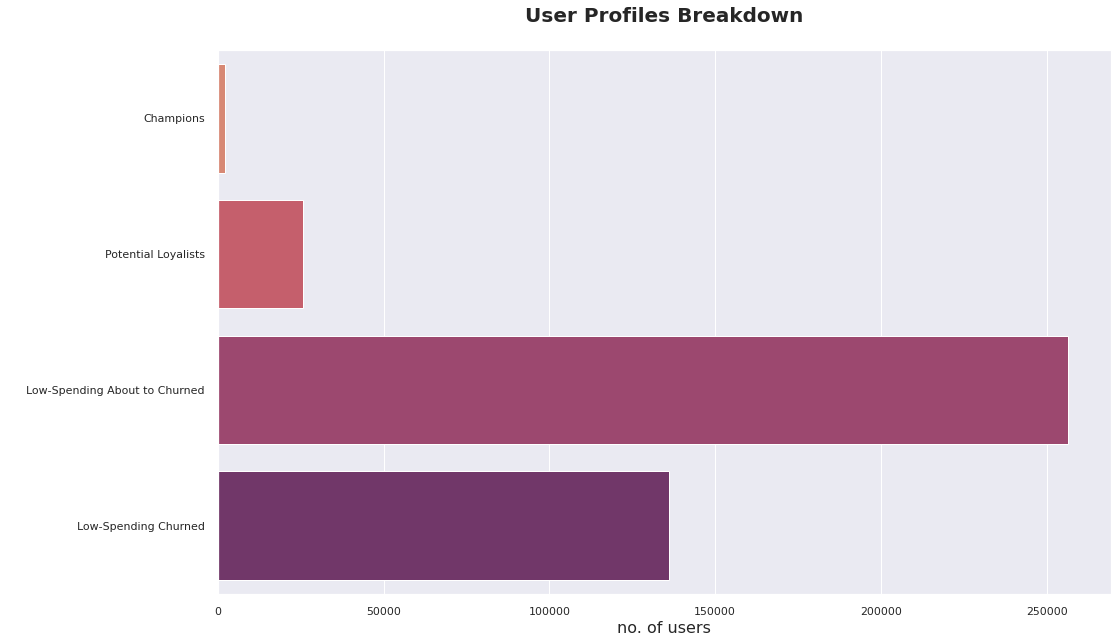

<Figure size 576x396 with 0 Axes>

In [ ]:
########################################
## RFM-BASED USERS PROFILES BREAKDOWN ##
########################################
cluster_order = ['Champions', 'Potential Loyalists', 'Low-Spending About to Churned', 'Low-Spending Churned']
plt.figure(figsize = (16, 10));
sns.barplot(data=user_clusters_profiles, y='Name', x='#_users', order=cluster_order, palette = "flare");
plt.title('User Profiles Breakdown\n', fontsize=20, weight = "bold");
plt.xlabel('no. of users',fontsize=16);
plt.ylabel(' ',fontsize=16);
plt.show();
plt.savefig('clusters-breakdown.png')

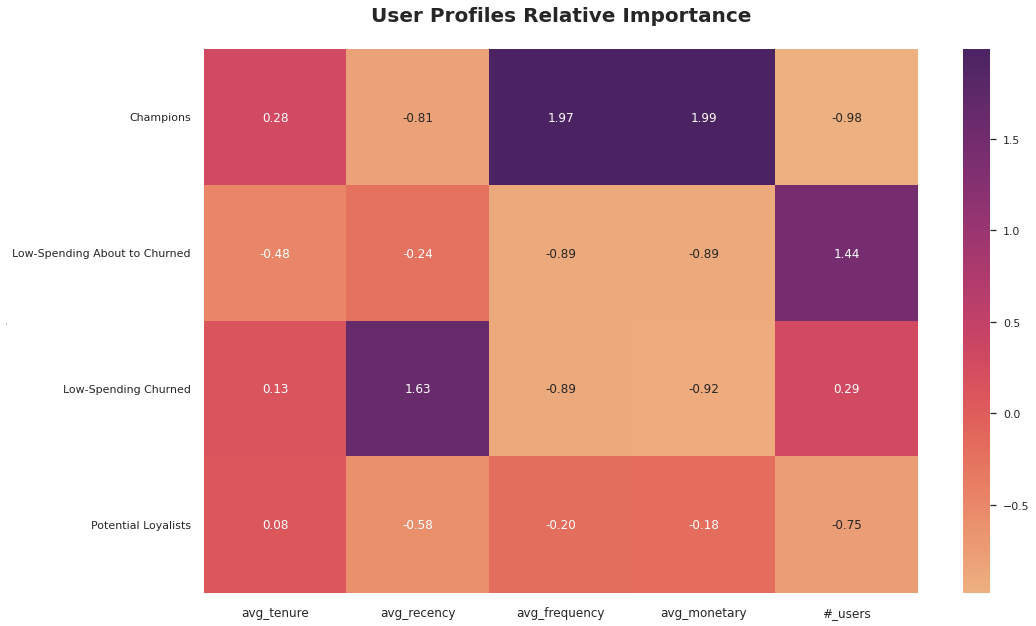

<Figure size 576x396 with 0 Axes>

In [ ]:
##################################################
## RFM-BASED USERS PROFILES RELATIVE IMPORTANCE ##
##################################################
cluster_avg = user_clusters_profiles.groupby(['Name']).mean()
population_avg = user_clusters_profiles.mean()
relative_importance = (cluster_avg / population_avg - 1).round(2)
plt.figure(figsize=(16, 10));
plt.title('User Profiles Relative Importance\n', fontsize=20, weight = "bold");
plt.ylabel(' ',fontsize=0);
plt.xticks(fontsize=12);
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='flare');
plt.show();
plt.savefig('clusters-relative-importance.png')

##### 6.1.2 **Recommendations**

> **Based on the insights above, marketing activities can be strategized and  customized to fit the different customers profiles:**
 

- **Champions ≈ 1%:**

   - These customers may be <u>rewarded</u> to stay <u>loyal</u> to our company. 
   - <u>Communication</u> with this group should make them feel <u>valued and appreciated</u>
   - Also, They can become early adopters of new products and will help promote the brand.


- **Potential Loyalists ≈ 6%:**

  - These customers may be offered <u>membership, loyalty programs or recommend related products</u> to upsell them and help to make them Champions.


- **Low-Spending Churned & About to Churned Customers ≈ 93%**
  
  - <u>Retention & reactivation</u> campaigns may be launched to make them order again, but it's also important to take their <u>CLVs</u> into consideration to be still <u>profitable customers</u>. 

### 6.2 CLTV-based Predictions

##### 6.2.1 Insights

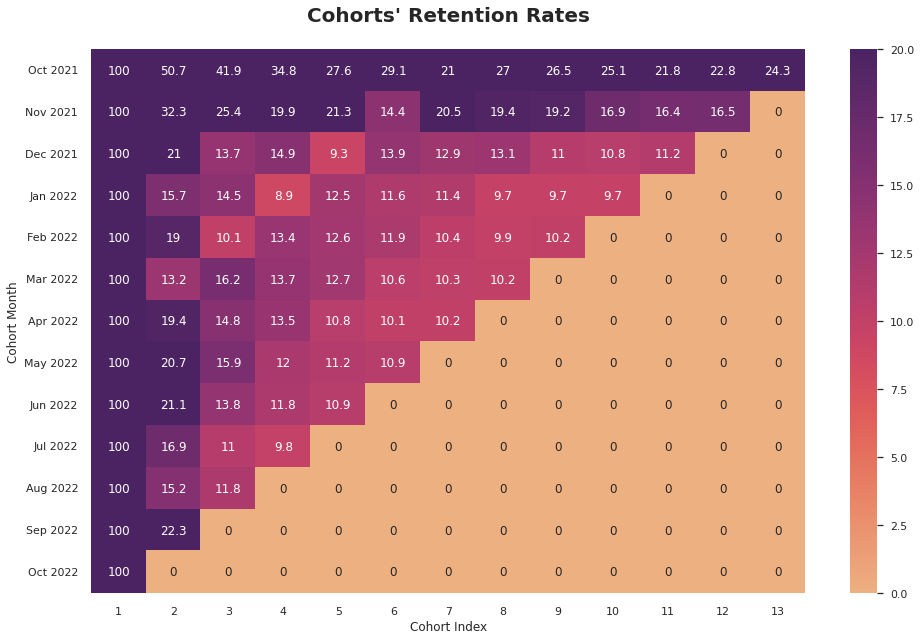

In [ ]:
##############################
## Cohorts' Retention Rates ##
##############################
plt.figure(figsize=(16, 10)); plt.title('Cohorts\' Retention Rates\n', fontsize = 20, weight = "bold");
sns.heatmap(retention_cohorts, annot = True,vmin = 0.0, vmax =20, cmap='flare' , fmt='g');
plt.ylabel('Cohort Month');  plt.xlabel('Cohort Index');
plt.yticks( rotation='360'); plt.show();

In [ ]:
####################################
## Segmenting Users Based on CLVs ##
####################################
clv_segments = clv.groupby('segment').mean().round(0).astype('int')
clv_segments.to_csv('11 data-clv-segments-profiles.csv')
display(clv_segments)

,recency (in days),tenure (in days),frequency,monetary,Cluster,6_months_expected_orders,6_monhths_clv
segment,,,,,,,
Hibernating,113,250,7,403,2,0,8
Need Attention,188,207,1,67,2,1,47
LoyalCustomers,136,159,2,100,1,2,119
Champions,97,120,3,193,1,4,639


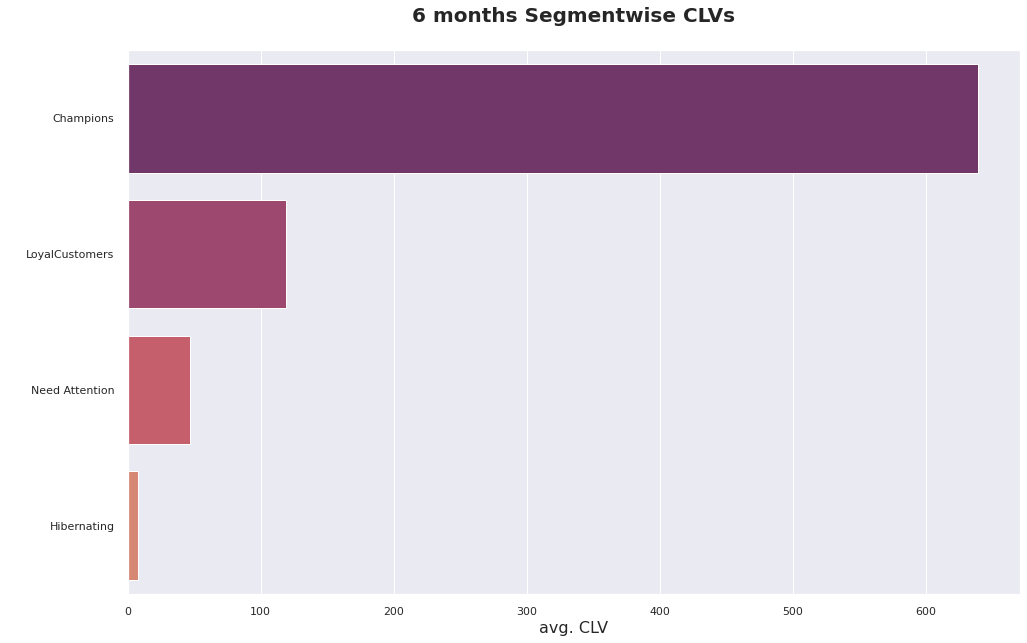

<Figure size 576x396 with 0 Axes>

In [ ]:
##################################
# Visualizing Segmentwise CLVs  ##
##################################
segment_order = ['Champions', 'LoyalCustomers', 'Need Attention', 'Hibernating']
plt.figure(figsize = (16, 10));
sns.barplot(data=clv_segments, y=clv_segments.index, x='6_monhths_clv', order=segment_order, palette = "flare_r");
plt.title('6 months Segmentwise CLVs\n', fontsize=20, weight = "bold");
plt.xlabel('avg. CLV',fontsize=16);
plt.ylabel(' ',fontsize=16);
plt.show();
plt.savefig('users-segment-CLV.png')

##### 6.2.2 Recommendations

- Referencing the heatmap above, it's obvious that **after the Nov 2021's cohort**, the company's **retention rate is decreasing drastically**. (i.e a lot of users are **churned**, which was observed above in the segmentation's results.)
 
- So, the marketing team needs to launch **activation & retention campaigns**. But, to still be operating efficiently, **CLVs** should be used in the campaigns' **budgeting and planning**.

- **Having known the CLVs, budgets for retention & activation campaigns will be set in a more feasible way**.

  (i.e customer retention or activation cost shouldn't be higher than his/her CLV)

- Below is the **CLV corresponding to every segment**:

    - Champions  ≈ 640
    - Loyal Customers ≈ 120
    - Need Attention ≈ 45
    - Hibernating ≈ 10

- **CLV improvement tips:**

  - **Automating customized marketing** actions using softwares.
  - Increasing **customer satisfaction** to prolong their customer lifespan
  - Encouraging additional purchases without increasing the marketing budget, which can be done by **selling complementary services**.


### 6.3 Business Performance Tracker


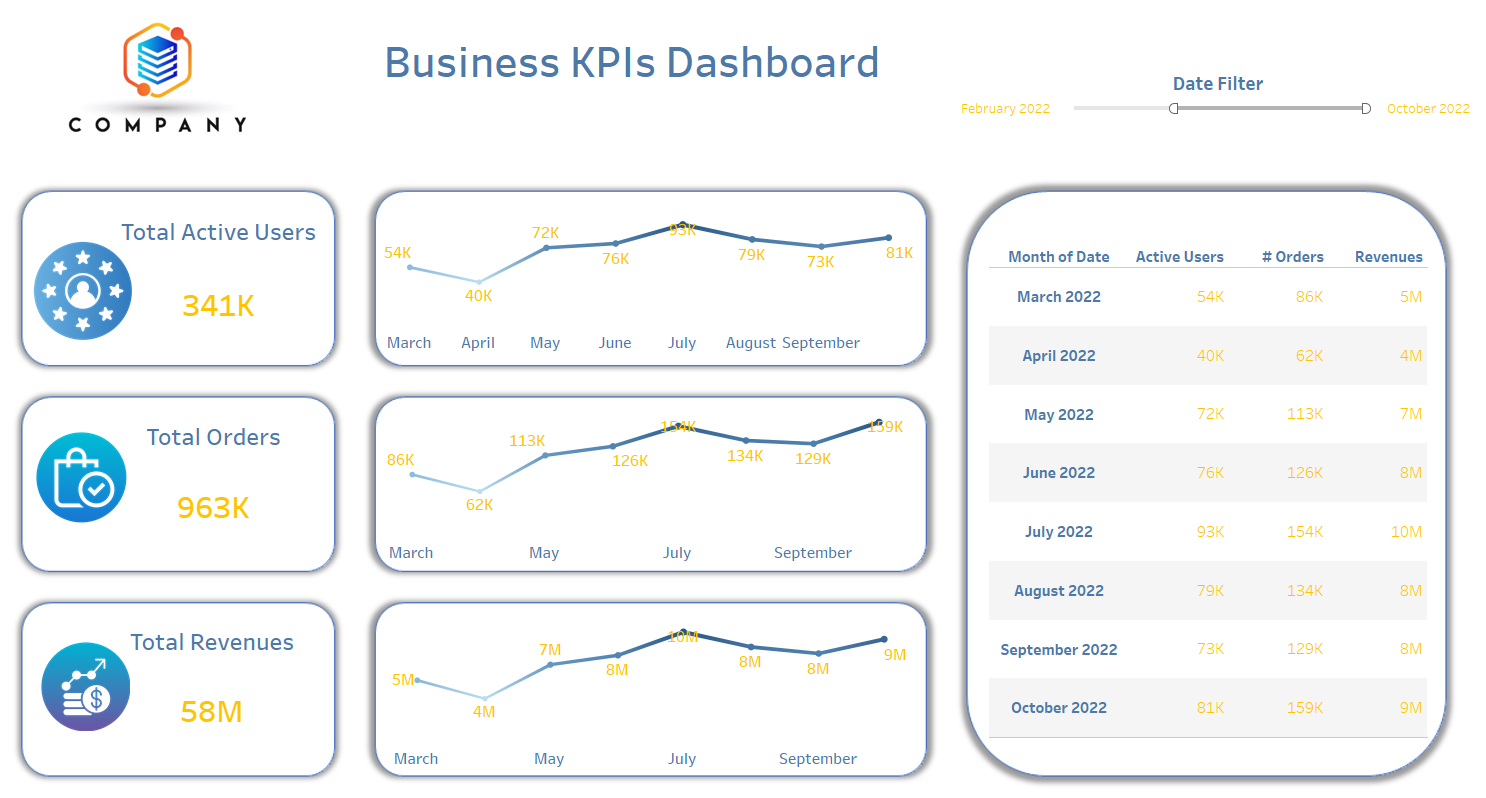

## **7. Conclusion**

> RFM-based customer segmentation using ML clustering algorithms is an excellent marketing tool for more customized and effective targeting.  

> Customer lifetime value prediction is a great way to get valuable insights into planning feasible and efficient customer acquisition, reactivation and retention.

> Business intelligence dashboards are indispensable tools for tracking business performance.


## **Author**

- <a href="https://www.linkedin.com/in/ayman-altaweel" target="_blank">Ayman Altaweel - LinkedIn</a>

- <a href="https://github.com/Ayman947?tab=repositories" target="_blank">Ayman Altaweel - Github</a>
